In [1]:
# TASK 2: DATA CLEANING
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

print("TASK 2: LÀM SẠCH DỮ LIỆU")

TASK 2: LÀM SẠCH DỮ LIỆU


In [2]:
# LOAD DỮ LIỆU
print("\n[0/5] Loading data...")

movies = pd.read_csv('../data/raw/movies_with_features.csv')
ratings = pd.read_csv('../data/raw/ratings.csv')
tags = pd.read_csv('../data/raw/tags.csv')

print(f"Loaded:")
print(f"Movies:  {len(movies):,} rows")
print(f"Ratings: {len(ratings):,} rows")
print(f"Tags:    {len(tags):,} rows")

# Backup original sizes
original_movies = len(movies)
original_ratings = len(ratings)
original_users = ratings['userId'].nunique()


[0/5] Loading data...
Loaded:
Movies:  62,423 rows
Ratings: 25,000,095 rows
Tags:    1,093,360 rows


In [3]:
# 2.1. XỬ LÝ MISSING VALUES
print("[1/5] XỬ LÝ MISSING VALUES")
print("\nMissing values trong MOVIES:")
missing_movies = movies.isnull().sum()
print(missing_movies[missing_movies > 0])

print("\nMissing values trong RATINGS:")
missing_ratings = ratings.isnull().sum()
print(missing_ratings[missing_ratings > 0])

# Xử lý missing values
print("\nĐang xử lý missing values...")

# Movies: Fill missing genres
if movies['genres'].isnull().sum() > 0:
    movies['genres'] = movies['genres'].fillna('Unknown')
    print(f"Đã fill {movies['genres'].isnull().sum()} missing genres → 'Unknown'")

# Movies: Fill missing year với median
if movies['year'].isnull().sum() > 0:
    median_year = movies['year'].median()
    movies['year'] = movies['year'].fillna(median_year)
    print(f"Đã fill missing year → median ({median_year})")

# Movies: Fill missing rating stats với 0
rating_cols = ['rating_avg', 'rating_count', 'rating_std']
for col in rating_cols:
    if col in movies.columns:
        movies[col] = movies[col].fillna(0)
        print(f"Đã fill missing {col} → 0")

# Movies: Fill missing tags
if 'tags_combined' in movies.columns:
    movies['tags_combined'] = movies['tags_combined'].fillna('')
    print(f"Đã fill missing tags → empty string")

# Ratings: Drop rows với missing values (nếu có)
ratings_before = len(ratings)
ratings = ratings.dropna()
ratings_dropped = ratings_before - len(ratings)
if ratings_dropped > 0:
    print(f"Đã xóa {ratings_dropped} ratings có missing values")
else:
    print(f"Ratings không có missing values")

# Tags: Drop rows với missing values
tags_before = len(tags)
tags = tags.dropna(subset=['tag'])
tags_dropped = tags_before - len(tags)
if tags_dropped > 0:
    print(f"Đã xóa {tags_dropped} tags có missing values")

print(f"\nHoàn thành xử lý missing values!")

[1/5] XỬ LÝ MISSING VALUES

Missing values trong MOVIES:
year               410
rating_avg        3376
rating_count      3376
rating_std       13674
tags_combined    17172
dtype: int64

Missing values trong RATINGS:
Series([], dtype: int64)

Đang xử lý missing values...
Đã fill missing year → median (2002.0)
Đã fill missing rating_avg → 0
Đã fill missing rating_count → 0
Đã fill missing rating_std → 0
Đã fill missing tags → empty string
Ratings không có missing values
Đã xóa 16 tags có missing values

Hoàn thành xử lý missing values!


In [4]:
# 2.2. LOẠI BỎ DUPLICATES
print("[2/5] LOẠI BỎ DUPLICATES")

# Duplicates trong Movies
print("\nKiểm tra duplicates trong MOVIES...")
movies_dup = movies.duplicated(subset=['movieId']).sum()
print(f"Duplicates: {movies_dup}")

if movies_dup > 0:
    movies = movies.drop_duplicates(subset=['movieId'], keep='first')
    print(f"Đã xóa {movies_dup} duplicate movies")
else:
    print(f"Không có duplicate movies")

# Duplicates trong Ratings
print("\nKiểm tra duplicates trong RATINGS...")
ratings_dup = ratings.duplicated(subset=['userId', 'movieId']).sum()
print(f"Duplicates: {ratings_dup}")

if ratings_dup > 0:
    # Giữ rating mới nhất (theo timestamp)
    ratings = ratings.sort_values('timestamp').drop_duplicates(
        subset=['userId', 'movieId'], 
        keep='last'
    )
    print(f"Đã xóa {ratings_dup} duplicate ratings (giữ rating mới nhất)")
else:
    print(f"Không có duplicate ratings")

# Duplicates trong Tags
print("\nKiểm tra duplicates trong TAGS...")
tags_dup = tags.duplicated(subset=['userId', 'movieId', 'tag']).sum()
print(f"   • Duplicates: {tags_dup}")

if tags_dup > 0:
    tags = tags.drop_duplicates(subset=['userId', 'movieId', 'tag'], keep='first')
    print(f"Đã xóa {tags_dup} duplicate tags")
else:
    print(f"Không có duplicate tags")

print(f"\nHoàn thành loại bỏ duplicates!")

[2/5] LOẠI BỎ DUPLICATES

Kiểm tra duplicates trong MOVIES...
Duplicates: 0
Không có duplicate movies

Kiểm tra duplicates trong RATINGS...
Duplicates: 0
Không có duplicate ratings

Kiểm tra duplicates trong TAGS...
   • Duplicates: 0
Không có duplicate tags

Hoàn thành loại bỏ duplicates!


[3/5] XỬ LÝ OUTLIERS

Phân bố số ratings per movie:
count    59047.000000
mean       423.393144
std       2477.885821
min          1.000000
25%          2.000000
50%          6.000000
75%         36.000000
max      81491.000000
dtype: float64
Đã lưu: figures/movie_rating_distribution.png


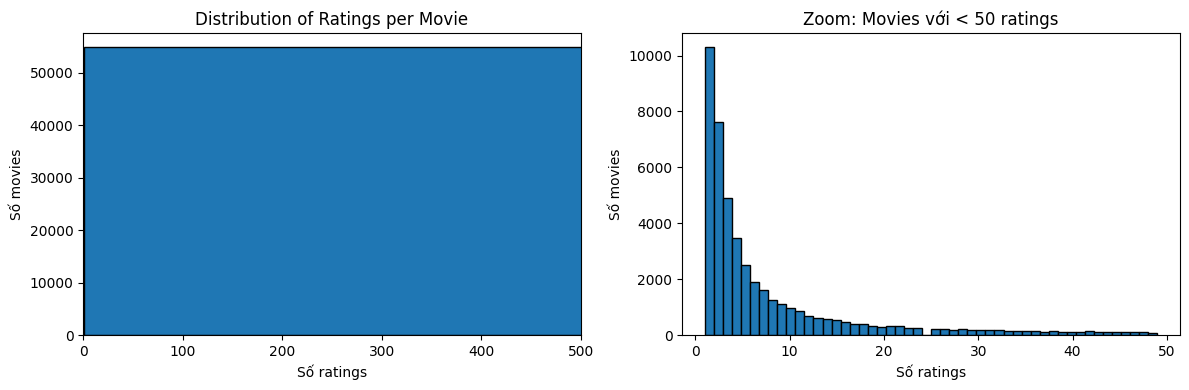


Loại bỏ movies có < 5 ratings...
Đã loại: 29,703 movies
Đã loại: 54,225 ratings tương ứng
   → Còn lại: 32,720 movies

Phân bố số ratings per user:
count    162541.000000
mean        153.474323
std         259.777208
min          11.000000
25%          36.000000
50%          71.000000
75%         162.000000
max       22348.000000
dtype: float64

Loại bỏ users có < 3 ratings...
Đã loại: 0 ratings từ inactive users
   → Còn lại: 162,541 users

Kiểm tra rating values...
   • Invalid ratings: 0
Tất cả ratings đều hợp lệ

Hoàn thành xử lý outliers!


In [5]:
# 2.3. XỬ LÝ OUTLIERS
print("[3/5] XỬ LÝ OUTLIERS")

# Đếm ratings cho mỗi movie
movie_rating_counts = ratings.groupby('movieId').size()
print(f"\nPhân bố số ratings per movie:")
print(movie_rating_counts.describe())

# Visualize distribution (optional - để trong notebook)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(movie_rating_counts, bins=100, edgecolor='black')
plt.xlabel('Số ratings')
plt.ylabel('Số movies')
plt.title('Distribution of Ratings per Movie')
plt.xlim(0, 500)

plt.subplot(1, 2, 2)
plt.hist(movie_rating_counts[movie_rating_counts < 50], bins=50, edgecolor='black')
plt.xlabel('Số ratings')
plt.ylabel('Số movies')
plt.title('Zoom: Movies với < 50 ratings')
plt.tight_layout()
plt.savefig('../figures/movie_rating_distribution.png', dpi=100, bbox_inches='tight')
print("Đã lưu: figures/movie_rating_distribution.png")
plt.show()

# Loại movies có quá ít ratings (< 5)
MIN_MOVIE_RATINGS = 5
print(f"\nLoại bỏ movies có < {MIN_MOVIE_RATINGS} ratings...")

valid_movies = movie_rating_counts[movie_rating_counts >= MIN_MOVIE_RATINGS].index
movies_before = len(movies)
movies = movies[movies['movieId'].isin(valid_movies)]
movies_removed = movies_before - len(movies)

ratings_before = len(ratings)
ratings = ratings[ratings['movieId'].isin(valid_movies)]
ratings_removed = ratings_before - len(ratings)

print(f"Đã loại: {movies_removed:,} movies")
print(f"Đã loại: {ratings_removed:,} ratings tương ứng")
print(f"   → Còn lại: {len(movies):,} movies")

# Đếm ratings cho mỗi user
user_rating_counts = ratings.groupby('userId').size()
print(f"\nPhân bố số ratings per user:")
print(user_rating_counts.describe())

# Loại users có quá ít ratings (< 3)
MIN_USER_RATINGS = 3
print(f"\nLoại bỏ users có < {MIN_USER_RATINGS} ratings...")

valid_users = user_rating_counts[user_rating_counts >= MIN_USER_RATINGS].index
ratings_before = len(ratings)
ratings = ratings[ratings['userId'].isin(valid_users)]
ratings_removed = ratings_before - len(ratings)

print(f"Đã loại: {ratings_removed:,} ratings từ inactive users")
print(f"   → Còn lại: {ratings['userId'].nunique():,} users")

# Kiểm tra ratings values (phải trong [0.5, 5.0])
print(f"\nKiểm tra rating values...")
invalid_ratings = ratings[(ratings['rating'] < 0.5) | (ratings['rating'] > 5.0)]
print(f"   • Invalid ratings: {len(invalid_ratings)}")

if len(invalid_ratings) > 0:
    print(f"   • Min rating: {ratings['rating'].min()}")
    print(f"   • Max rating: {ratings['rating'].max()}")
    ratings = ratings[(ratings['rating'] >= 0.5) & (ratings['rating'] <= 5.0)]
    print(f"Đã xóa {len(invalid_ratings)} invalid ratings")
else:
    print(f"Tất cả ratings đều hợp lệ")

print(f"\nHoàn thành xử lý outliers!")

In [6]:
# 2.4. CHUẨN HÓA DỮ LIỆU
print("[4/5] CHUẨN HÓA DỮ LIỆU")

# Lowercase genres
print("\nChuẩn hóa genres...")
movies['genres'] = movies['genres'].str.lower()
print("Đã lowercase genres")

# Lowercase và clean tags
if 'tags_combined' in movies.columns:
    print("\nChuẩn hóa tags...")
    movies['tags_combined'] = movies['tags_combined'].str.lower()
    # Remove special characters
    movies['tags_combined'] = movies['tags_combined'].str.replace(r'[^a-z0-9\s]', ' ', regex=True)
    # Remove extra whitespace
    movies['tags_combined'] = movies['tags_combined'].str.replace(r'\s+', ' ', regex=True).str.strip()
    print("Đã clean và lowercase tags")

# Đảm bảo year là integer
movies['year'] = movies['year'].astype('Int64')  # Int64 hỗ trợ NaN
print("Đã convert year sang integer")

# Re-index userId và movieId về dãy liên tiếp (0, 1, 2, ...)
print("\nRe-indexing IDs...")

# Tạo mapping
user_id_map = {old_id: new_id for new_id, old_id in enumerate(ratings['userId'].unique())}
movie_id_map = {old_id: new_id for new_id, old_id in enumerate(movies['movieId'].unique())}

# Save mapping để dùng sau
with open('../models/user_id_map.pkl', 'wb') as f:
    pickle.dump(user_id_map, f)
with open('../models/movie_id_map.pkl', 'wb') as f:
    pickle.dump(movie_id_map, f)

print(f"User IDs: {len(user_id_map):,} unique users")
print(f"Movie IDs: {len(movie_id_map):,} unique movies")
print(f"Đã lưu: models/user_id_map.pkl, models/movie_id_map.pkl")

# Sort ratings theo timestamp
ratings = ratings.sort_values(['userId', 'timestamp']).reset_index(drop=True)
print("Đã sort ratings theo timestamp")

print(f"\nHoàn thành chuẩn hóa dữ liệu!")

[4/5] CHUẨN HÓA DỮ LIỆU

Chuẩn hóa genres...
Đã lowercase genres

Chuẩn hóa tags...
Đã clean và lowercase tags
Đã convert year sang integer

Re-indexing IDs...
User IDs: 162,541 unique users
Movie IDs: 32,720 unique movies
Đã lưu: models/user_id_map.pkl, models/movie_id_map.pkl
Đã sort ratings theo timestamp

Hoàn thành chuẩn hóa dữ liệu!


In [7]:
# 2.5. TF-IDF VECTORIZATION
print("[5/5] TF-IDF VECTORIZATION")

# Combine genres và tags thành content
print("\nTạo content field...")

# Prepare content: genres + tags
movies['content'] = movies['genres'].str.replace('|', ' ')

if 'tags_combined' in movies.columns:
    # Kết hợp genres và tags
    movies['content'] = movies['content'] + ' ' + movies['tags_combined'].fillna('')
    print("Content = genres + tags")
else:
    print("Content = genres only")

# Remove extra whitespace
movies['content'] = movies['content'].str.replace(r'\s+', ' ', regex=True).str.strip()

print(f"\nSample content:")
print(movies[['title_clean', 'content']].head(3))

# TF-IDF Vectorization
print(f"\nTF-IDF Vectorization...")

tfidf = TfidfVectorizer(
    max_features=5000,           # Top 5000 features
    stop_words='english',         # Remove English stop words
    ngram_range=(1, 2),          # Unigrams and bigrams
    min_df=2,                     # Ignore terms in < 2 documents
    max_df=0.8                    # Ignore terms in > 80% documents
)

tfidf_matrix = tfidf.fit_transform(movies['content'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_):,}")
print(f"Sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))*100:.2f}%")

# Save TF-IDF
print(f"\nSaving TF-IDF objects...")

with open('../models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("Đã lưu: models/tfidf_vectorizer.pkl")

with open('../models/tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)
print("Đã lưu: models/tfidf_matrix.pkl")

# Top features
print(f"\nTop 20 TF-IDF features:")
feature_names = tfidf.get_feature_names_out()
print(list(feature_names[:20]))

print(f"\nHoàn thành TF-IDF vectorization!")


[5/5] TF-IDF VECTORIZATION

Tạo content field...
Content = genres + tags

Sample content:
        title_clean                                            content
0         Toy Story  adventure animation children comedy fantasy ow...
1           Jumanji  adventure children fantasy robin williams time...
2  Grumpier Old Men  comedy romance funny best friend duringcredits...

TF-IDF Vectorization...
TF-IDF matrix shape: (32720, 5000)
Vocabulary size: 5,000
Sparsity: 99.61%

Saving TF-IDF objects...
Đã lưu: models/tfidf_vectorizer.pkl
Đã lưu: models/tfidf_matrix.pkl

Top 20 TF-IDF features:
['007', '007 series', '01', '01 10', '01 11', '01 12', '02', '02 11', '03', '03 10', '03 11', '04', '04 11', '05', '05 10', '05 11', '06', '06 10', '06 11', '07']

Hoàn thành TF-IDF vectorization!


In [8]:
# LƯU DỮ LIỆU ĐÃ CLEAN
print("LƯU DỮ LIỆU ĐÃ CLEAN")

# Tạo folder nếu chưa có
os.makedirs('../data/cleaned', exist_ok=True)

# Save cleaned data
movies.to_csv('../data/cleaned/movies_clean.csv', index=False)
print(f"Đã lưu: data/cleaned/movies_clean.csv")

ratings.to_csv('../data/cleaned/ratings_clean.csv', index=False)
print(f"Đã lưu: data/cleaned/ratings_clean.csv")

tags.to_csv('../data/cleaned/tags_clean.csv', index=False)
print(f"Đã lưu: data/cleaned/tags_clean.csv")


LƯU DỮ LIỆU ĐÃ CLEAN
Đã lưu: data/cleaned/movies_clean.csv
Đã lưu: data/cleaned/ratings_clean.csv
Đã lưu: data/cleaned/tags_clean.csv


In [9]:
# TỔNG KẾT
print("TỔNG KẾT TASK 2")

print(f"\nThống kê TRƯỚC và SAU cleaning:")
print(f"\n   MOVIES:")
print(f"Trước: {original_movies:,}")
print(f"Sau:   {len(movies):,}")
print(f"Giảm:  {original_movies - len(movies):,} ({(original_movies - len(movies))/original_movies*100:.1f}%)")

print(f"\n   RATINGS:")
print(f"Trước: {original_ratings:,}")
print(f"Sau:   {len(ratings):,}")
print(f"Giảm:  {original_ratings - len(ratings):,} ({(original_ratings - len(ratings))/original_ratings*100:.1f}%)")

print(f"\n   USERS:")
print(f"Trước: {original_users:,}")
print(f"Sau:   {ratings['userId'].nunique():,}")
print(f"Giảm:  {original_users - ratings['userId'].nunique():,} ({(original_users - ratings['userId'].nunique())/original_users*100:.1f}%)")

print(f"\nCÁC TÁC VỤ ĐÃ HOÀN THÀNH:")
print(f"1. Xử lý Missing Values")
print(f"2. Loại bỏ Duplicates")
print(f"3. Xử lý Outliers")
print(f"4. Chuẩn hóa dữ liệu")
print(f"5. TF-IDF Vectorization")

print("🎉 TASK 2 HOÀN THÀNH!")


TỔNG KẾT TASK 2

Thống kê TRƯỚC và SAU cleaning:

   MOVIES:
Trước: 62,423
Sau:   32,720
Giảm:  29,703 (47.6%)

   RATINGS:
Trước: 25,000,095
Sau:   24,945,870
Giảm:  54,225 (0.2%)

   USERS:
Trước: 162,541
Sau:   162,541
Giảm:  0 (0.0%)

CÁC TÁC VỤ ĐÃ HOÀN THÀNH:
1. Xử lý Missing Values
2. Loại bỏ Duplicates
3. Xử lý Outliers
4. Chuẩn hóa dữ liệu
5. TF-IDF Vectorization
🎉 TASK 2 HOÀN THÀNH!
